# Play with exponential fits 

We use data from the files at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Thank you @CSSEGISandData for providing the data!

In [1]:
%config InlineBackend.figure_formats = ['svg']
import math
from numpy import log, exp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
figsize = (11, 4)   # need bigger size otherwise xlabels are cut-off in svg files

import os
import pandas as pd
import seaborn as sb
sb.set_style('darkgrid')
import scipy
import numpy as np
import iminuit

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def string_to_date(input_):
    """Converts string of type 01/22/02 [for 22 Jan 2020] into datetime object"""
    # return pd.to_datetime(input_, format='%m/%d/%y', errors='ignore')
    return pd.to_datetime(input_, format='%m/%d/%y')

def set_date_formatting(ax):
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', rotation=90)

# read data from web
#

def fetch_data(names = ['confirmed', 'deaths']):
    """Return 3 data frames:
    [confirmed, deaths], location_info
    
    where confirmed, deaths and recovered are data frames with countries/regions in the rows, and 
    days in the columns
    
    and location_info provides additional information about the locations.
    
    We assume all three tables have the same entries"""
    location_info = pd.DataFrame()
    dfs = []
    for name in names:
        url = os.path.join(base_url, "time_series_covid19_" + name + "_global.csv")
        df = pd.read_csv(url, index_col=1)
    
        if not name == 'Recovered':
            location_info['Lat'] = df['Lat']
            location_info['Long'] = df['Long']
            location_info['Province/State'] = df['Province/State']
            location_info['location'] = df.index + "-" + df['Province/State']
        else:
            pass  # no location info in recovered since 14 March
        ## df = df.drop(labels=["Lat", "Long", "Province/State"], axis=1)
        df = df.drop(labels=["Lat", "Long"], axis=1)
        
        # extract dates from strings
        dates = string_to_date(df.columns[1:])        
        # use those objects as new column labels
        df.columns = [df.columns[0]] + list(dates)
        print(f"{name:10}: last data point from {max(dates[1:])}")
        # dfs.append([df, location_info)
        dfs.append(df)

    return dfs


confirmed, deaths = fetch_data()

# show counries with mosth deaths
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[0:10,-8:]

confirmed : last data point from 2020-03-31 00:00:00
deaths    : last data point from 2020-03-31 00:00:00


,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00
Country/Region,,,,,,,,
Italy,6820,7503,8215,9134,10023,10779,11591,12428
Spain,2808,3647,4365,5138,5982,6803,7716,8464
US,706,942,1209,1581,2026,2467,2978,3873
France,1100,1331,1696,1995,2314,2606,3024,3523
China,3160,3163,3169,3174,3177,3182,3186,3187
Iran,1934,2077,2234,2378,2517,2640,2757,2898
United Kingdom,422,465,578,759,1019,1228,1408,1789
Netherlands,276,356,434,546,639,771,864,1039
Germany,157,206,267,342,433,533,645,775


In [2]:
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[:,-8:]


,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00
Country/Region,,,,,,,,
Italy,6820,7503,8215,9134,10023,10779,11591,12428
Spain,2808,3647,4365,5138,5982,6803,7716,8464
US,706,942,1209,1581,2026,2467,2978,3873
France,1100,1331,1696,1995,2314,2606,3024,3523
China,3160,3163,3169,3174,3177,3182,3186,3187
...,...,...,...,...,...,...,...,...
Chad,0,0,0,0,0,0,0,0
Mongolia,0,0,0,0,0,0,0,0
Malta,0,0,0,0,0,0,0,0


In [3]:
def double_time_exponential(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate(double_time):
    return log(2)/double_time

def double_time(growth_rate):
    return log(2)/growth_rate


# t1, t2, q1, q2 = 0, 1, 1, 2
# double_time_exponential(t1, t2, q1, q2), growth_rate(double_time_exponential(t1, t2, q1, q2) )

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    # print(f"double_time_exponential: {q2_div_q1}, {t2_minus_t1} ")
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
        # print(f"shape t: {t2_minus_t1.shape}, shape q: {q2_div_q1.shape}")
        # print(f"type t: {type(t2_minus_t1)}, type q: {type(q2_div_q1.shape)}")

    return t2_minus_t1 * np.log(2) / np.log(q2_div_q1) 


def stack_country(country = "Germany"):

    #create one DataFrame for country/region
    c_df = pd.DataFrame()
    if country == "United Kingdom":
        # UK has many provinces that keep changing. Sum to get all (most relevant is mainland UK)
        c_df['confirmed'] = confirmed.loc[country].sum()
        c_df['deaths'] = deaths.loc[country].sum()
    elif country == "China": 
        # Use only Hubei province
        tmp = confirmed.loc[country]
        c_df['confirmed'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        tmp = deaths.loc[country]
        c_df['deaths'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        c_df.drop("Province/State", inplace=True)
    elif country in ['France']:
        c_df['confirmed'] = confirmed.loc[country].sum()
        c_df['deaths'] = deaths.loc[country].sum()
        c_df.drop('Province/State', inplace=True)
    elif country in ['US']:
        c_df['confirmed'] = confirmed.loc[country]
        c_df['deaths'] = deaths.loc[country]
    else:
        c_df['confirmed'] = confirmed.loc[country].drop('Province/State')
        c_df['deaths'] = deaths.loc[country].drop('Province/State')

    # drop days with confirmed cases = 0
    c1 = c_df[c_df['confirmed'] != 0][1:]
    
    # drop another row
    c_df = c1
  
    c_df.index = string_to_date(c_df.index)
    c_df.country = country  # remember which country we work on, just in case
    
    c_df['days-td'] = c_df.index - c_df.index.min()  # days as TimeDelta type
    c_df['days'] = c_df['days-td'].astype("timedelta64[D]").astype(float)
    
    c_df['new_confirmed'] = c_df['confirmed'].diff()
    c_df['new_deaths'] = c_df['deaths'].diff()
    
    c_df['confirmed_pct'] = c_df['confirmed'].pct_change()+1
    c_df['deaths_pct'] = c_df['deaths'].pct_change()+1
    
    #return c_df
    # growth rate
    c_df['deaths_double_time'] = double_time_exponential(c_df['deaths_pct'].values)
    c_df['confirmed_double_time'] = double_time_exponential(c_df['confirmed_pct'].values)
    c_df['deaths_growth_rate'] = growth_rate(c_df['deaths_double_time'].values)
    c_df['confirmed_growth_rate'] = growth_rate(c_df['confirmed_double_time'].values)

    return c_df

In [4]:

c = stack_country("Germany")
#c.tail(n=5)
c2 = stack_country("United Kingdom")
#c.tail(n=5)
#c2 = stack_country("Spain")
#c.tail(n=5)
#c2 = stack_country("Italy")
#c2.tail(n=5)
#c2 = stack_country("France")
#c2.tail(n=5)
#c2 = stack_country("China")
#c2 = stack_country("US")

c

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


,confirmed,deaths,days-td,days,new_confirmed,new_deaths,confirmed_pct,deaths_pct,deaths_double_time,confirmed_double_time,deaths_growth_rate,confirmed_growth_rate
2020-01-28,4,0,0 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,4,0,1 days,1.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-30,4,0,2 days,2.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-31,5,0,3 days,3.0,1,0,1.250000,NaN,NaN,3.106284,NaN,0.223144
2020-02-01,8,0,4 days,4.0,3,0,1.600000,NaN,NaN,1.474770,NaN,0.470004
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,50871,342,59 days,59.0,6933,75,1.157791,1.280899,2.799892,4.730945,0.247562,0.146513
2020-03-28,57695,433,60 days,60.0,6824,91,1.134143,1.266082,2.937973,5.506522,0.235927,0.125877
2020-03-29,62095,533,61 days,61.0,4400,100,1.076263,1.230947,3.335907,9.431221,0.207784,0.073495
2020-03-30,66885,645,62 days,62.0,4790,112,1.077140,1.210131,3.634201,9.327871,0.190729,0.074309


In [5]:
confirmed.loc["US"]

Province/State            NaN
2020-01-22 00:00:00         1
2020-01-23 00:00:00         1
2020-01-24 00:00:00         2
2020-01-25 00:00:00         2
                        ...  
2020-03-27 00:00:00    101657
2020-03-28 00:00:00    121478
2020-03-29 00:00:00    140886
2020-03-30 00:00:00    161807
2020-03-31 00:00:00    188172
Name: US, Length: 71, dtype: object

In [33]:
def overview_plot(c_df, rollingwindow=7):
    """expect """
    fig, axes = plt.subplots(4, 1, figsize=(8, 14))
    ax = axes[0]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['confirmed'], '-b', label='confirmed')
    ax.plot(c_df.index, c_df['deaths'], '-r', label='deaths')
    ax.legend(loc='center left')
    country = c_df.country
    ax.set_title(country + " accumulated data")
    ax.set_yscale('log')

    ax = axes[1]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['confirmed'].diff(), 'ob', label='day-to-day change confirmed')
    ax.plot(c_df.index, c_df['deaths'].diff(), 'xr', label='day-to-day change deaths')
    ax.legend(loc='center left')
    #ax.set_yscale('log')
    

    ax = axes[2]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_double_time'], 'xr', label='double time deaths')
    ax.plot(c_df.index, c_df['deaths_double_time'].rolling(rollingwindow, center=True).mean(),
            '-r', label='double time deaths rolling')
    ax.plot(c_df.index, c_df['confirmed_double_time'], 'ob', label='double time confirmed')
    ax.plot(c_df.index, c_df['confirmed_double_time'].rolling(rollingwindow, center=True).mean(), 
            '-b', label='double time confirmed rolling')
    ax.legend(loc='center left')
    ax.set_ylabel('days to double numbers \n bigger is better')
    maxy = min(20, max(c_df['confirmed_double_time']))
    ax.set_ylim(0, maxy)

    ax = axes[3]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_growth_rate'], 'xr', label='growth rate deaths')
    ax.plot(c_df.index, c_df['deaths_growth_rate'].rolling(rollingwindow, center=True).mean(), 'r-', label='growth rate deaths rolling')
    ax.plot(c_df.index, c_df['confirmed_growth_rate'], 'ob', label='confirmed growth rate')
    ax.plot(c_df.index, c_df['confirmed_growth_rate'].rolling(rollingwindow, center=True).mean(), 
            'b-', label='confirmed growth rate rolling')
    ax.legend(loc='center left')
    ax.set_ylim(0, 0.5)
    ax.set_ylabel('growth rate r in\n f(t) = exp(r*t)\n(smaller is better)')
    
    # fig.savefig(f"figures/{country}-overview.svg")
    return axes

In [7]:
china = stack_country('China')
germany = stack_country('Germany')
uk = stack_country("United Kingdom")
us = stack_country("US")

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e846c90>,
      dtype=object)

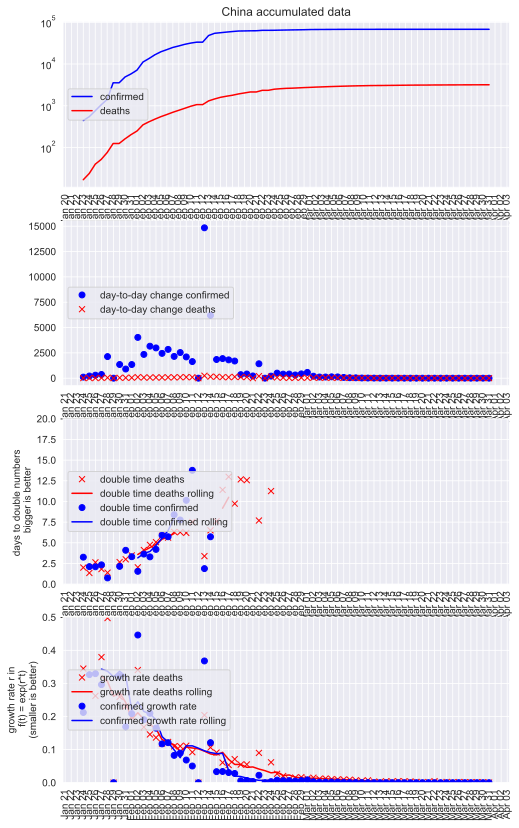

In [34]:
overview_plot(china)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1eecda90>,
      dtype=object)

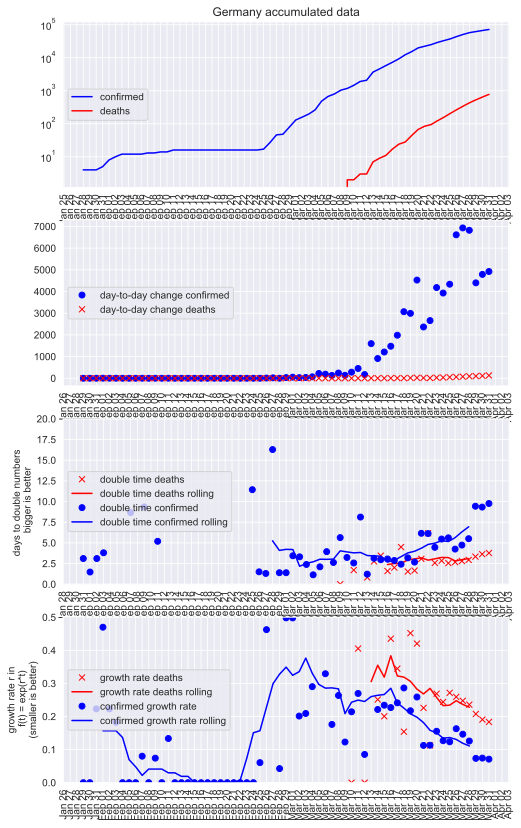

In [35]:
overview_plot(germany)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f104c50>,
      dtype=object)

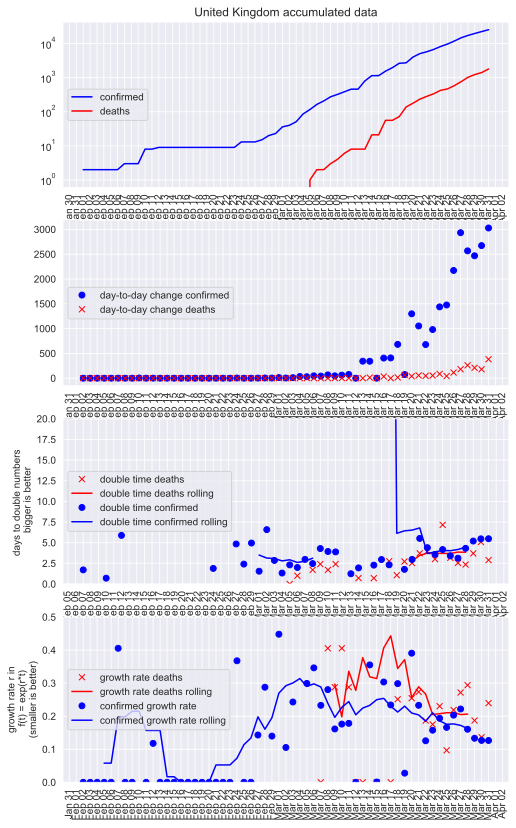

In [36]:
overview_plot(uk)

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f62b910>,
      dtype=object)

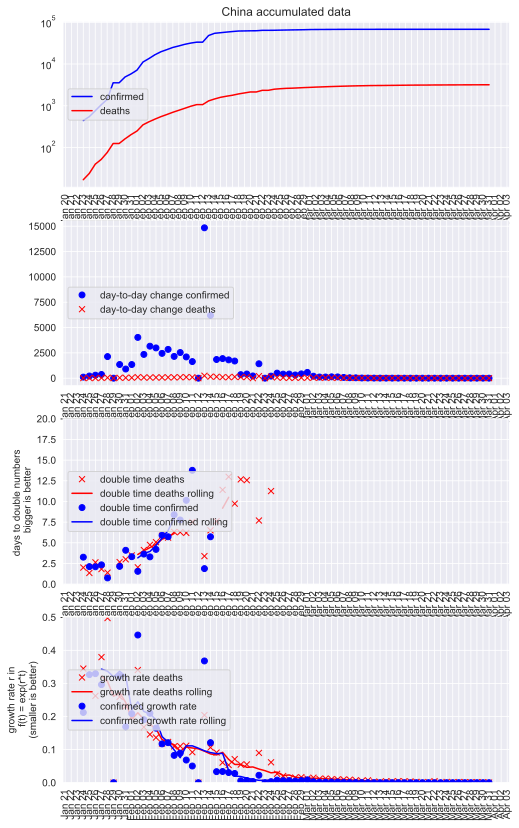

In [37]:
c = stack_country('China')
overview_plot(c)

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


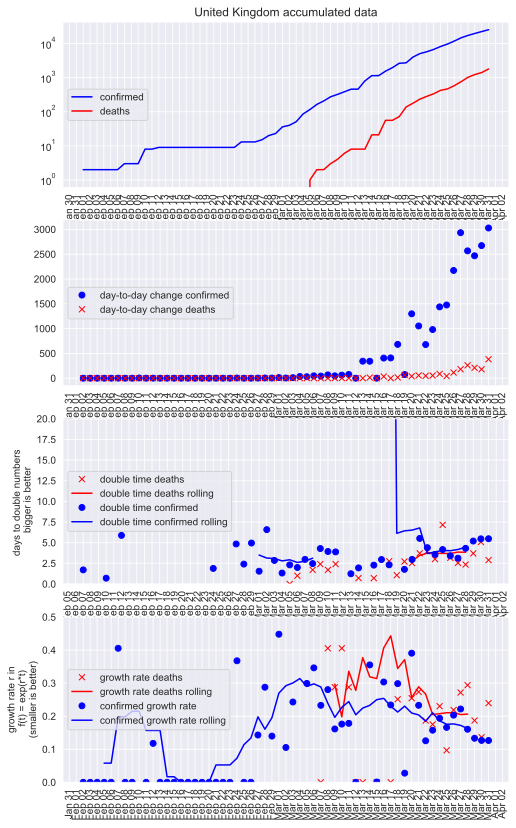

In [38]:
uk = stack_country('United Kingdom')
overview_plot(uk);

In [13]:
# compute doubling time (and growth rate) for a longer sequence of days (by fitting)


reduced chi^2: 0.3972547259031033
r   : 0.0528
t0  : -31.6
a0  : -4.28



------------------------------------------------------------------
| FCN = 0.3973                  |     Ncalls=237 (237 total)     |
| EDM = 0.000161 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | r    |   0.05    |   0.04    |            |            |         |         |       |
| 1 | t0   |    -32    |     52    |            |            |         |         |       |
| 2 | a0   |    -4     |     10    |            |            |         |         |       |
------------------------------------------------------------------------------------------

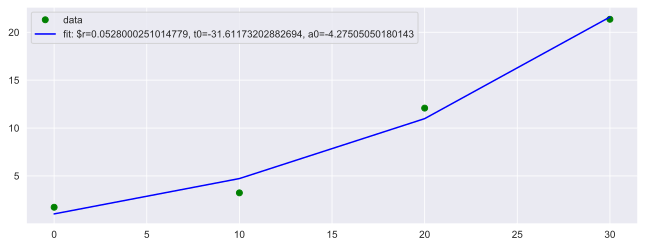

In [14]:
def pretty_params(**par):
    end='\n'
    s = ""
    for p in par:
        s += f"{p:3} : {par[p]:.3g}" + end
    return s


def model(xdata, r, t0, a0):
    return np.exp(r*(xdata-t0))+a0



def exp_fit(xdata, ydata, p0):
    r, t0, a0 = p0
    
    def least_squares(r, t0, a0):
        yvar = 10
        return sum((ydata - model(xdata, r, t0, a0))**2)/yvar
    
    m = iminuit.Minuit(least_squares, 
                       r=r, t0=t0, a0=a0, error_r=0.02, error_t0=0.2, error_a0=1, 
                       errordef=1)
    res = m.migrad()
    print(f"reduced chi^2: {m.fval / (len(ydata) - 3)}")
    r, t0, a0 = m.np_values()
    print(pretty_params(r=r, t0=t0, a0=a0))
    
    return m, res

def plot(xdata, ydata, r, t0, a0, annotate=""):
    #r, t0, a0 = m.np_values()

    fitted = model(xdata, r, t0, a0)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(xdata, ydata, 'og')
    ax.plot(xdata, fitted, '-b')
    ax.legend(["data", f"fit: $r={r}, t0={t0}, a0={a0}"])
    #ax.set_title(f"Infections $n(t)$ ({pretty_params(param_infections, end=', ')})")
    ax.set_title(annotate)
    #ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    #ax.tick_params(axis='x', rotation=90)
    #fig.savefig('figures/infections-with-model-fit.svg')
    # print(fitted_infections)
    return ax

def test_model(): 
    xdata = np.linspace(0, 30, 4)
    ydata = 0 + np.exp(0.1*(xdata - 0)) + 5*np.random.random_sample(xdata.shape)    
    m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
    r, t0, a0 = m.np_values()
    plot(xdata, ydata, r, t0, a0)
    return res, m, xdata, ydata


res, m, xdata, ydata = test_model()
res


reduced chi^2: 0.012586982852334335
r   : 0.0367
t0  : 37.9
a0  : 6.78e+04

Double time: 18.9 days


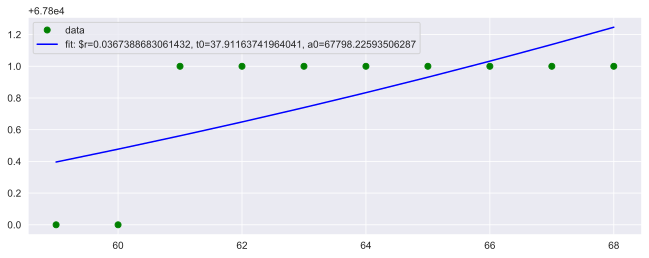

In [15]:
# Exponential fit through last n days
series = c['confirmed']
start = -10
end = None
xdata_0 = (series.index[start:end] - series.index[0])
xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
ydata = series.values[start:end]
# Attempt fit
m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
r, t0, a0 = m.np_values()
plot(xdata, ydata, r, t0, a0)
print(f"Double time: {double_time(r):.1f} days")


reduced chi^2: 0.32283133777435896
r   : 0.0105
t0  : -506
a0  : 2.77e+03

Double time: 65.9 days


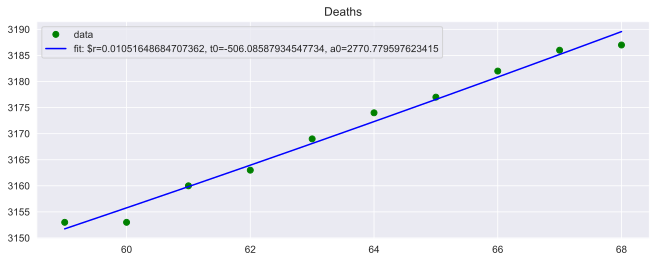

In [16]:
# Exponential fit through last n days, deaths
series = c['deaths']
start = -10
end = None
xdata_0 = (series.index[start:end] - series.index[0])
xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
ydata = series.values[start:end]
# Attempt fit
m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
r, t0, a0 = m.np_values()
ax = plot(xdata, ydata, r, t0, a0)
ax.set_title("Deaths")
print(f"Double time: {double_time(r):.1f} days")


In [17]:
def grow_rate_n_days(series, n=7):
    """Use the last 4 data points to estimate growth rate (and doubling time) for each day"""
    par = pd.DataFrame(index=series.index, columns=['r', 't0', 'a0', 'chi2'])
    print(f"Data stack shape = {series.shape}")
    for i in range(n, len(series)):
        start = i-n
        end = i
        print(f"Working on {start} to {end}, this is {start}/{len(series-n)}")
        xdata_0 = (series.index[start:end] - series.index[0])
        xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
        ydata = series.values[start:end]
        # Attempt fit
        m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
        r, t0, a0 = m.np_values()
        par.iloc[i].at['r'] = r
        par.iloc[i].at['t0'] = t0
        par.iloc[i].at['a0'] = a0
        print(f"r={r:10}, t0={t0:10}, a0={a0:10}")
        plot(xdata, ydata, r, t0, a0)
            
    return par

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Data stack shape = (20,)
Working on 0 to 7, this is 0/20
reduced chi^2: 10867.512179553933
r   : 0.223
t0  : -36.6
a0  : -1e+03

r=0.22270404120428178, t0=-36.586831349652925, a0=-1003.6458347196473
Working on 1 to 8, this is 1/20
reduced chi^2: 3283.6684497557762
r   : 0.258
t0  : -30.3
a0  : 439

r=0.2575466749732122, t0=-30.335121549029193, a0=438.824374812927
Working on 2 to 9, this is 2/20
reduced chi^2: 3206.4122025994034
r   : 0.255
t0  : -30.8
a0  : 310

r=0.2547528152202622, t0=-30.78114336566038, a0=309.5188731507096
Working on 3 to 10, this is 3/20
reduced chi^2: 43679.337591242904
r   : 0.13
t0  : -70.6
a0  : -9.23e+03

r=0.1303014439670329, t0=-70.60800622946535, a0=-9231.021520722954
Working on 4 to 11, this is 4/20
reduced chi^2: 48461.40910604926
r   : 0.0233
t0  : -500
a0  : -1.16e+05

r=0.02328128509490354, t0=-499.50883292246573, a0=-116484.49097463647
Working on 5 to 12, this is 5/20


/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


reduced chi^2: 37205.1475044525
r   : 0.0153
t0  : -795
a0  : -1.95e+05

r=0.015276062060096487, t0=-795.3119928283066, a0=-194628.58420656738
Working on 6 to 13, this is 6/20
reduced chi^2: 42396.15081771496
r   : 0.0266
t0  : -434
a0  : -1.05e+05

r=0.02655325692339948, t0=-433.5689401011983, a0=-104766.90319003626
Working on 7 to 14, this is 7/20
reduced chi^2: 41959.28783782637
r   : 0.0703
t0  : -144
a0  : -2.46e+04

r=0.07028566066434232, t0=-143.96173618713894, a0=-24626.88459744035
Working on 8 to 15, this is 8/20
reduced chi^2: 13526.268389333272
r   : 0.179
t0  : -44.7
a0  : 7.36e+03

r=0.17876298459426526, t0=-44.7499885816739, a0=7356.631405669698
Working on 9 to 16, this is 9/20
reduced chi^2: 13430.119233283607
r   : 0.177
t0  : -45.5
a0  : 7.02e+03

r=0.1766601936712742, t0=-45.50227464700307, a0=7019.369920301536
Working on 10 to 17, this is 10/20
reduced chi^2: 24479.254469237498
r   : 0.142
t0  : -61.2
a0  : 370

r=0.1419068164834201, t0=-61.24297743360214, a0=370.033

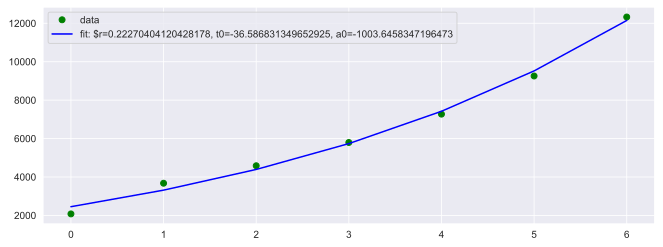

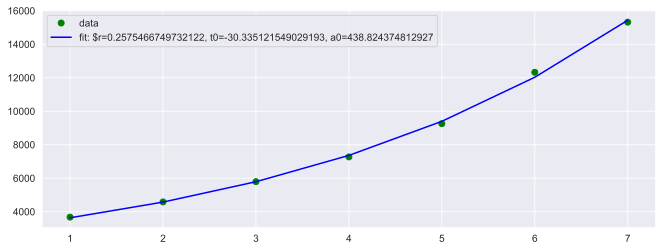

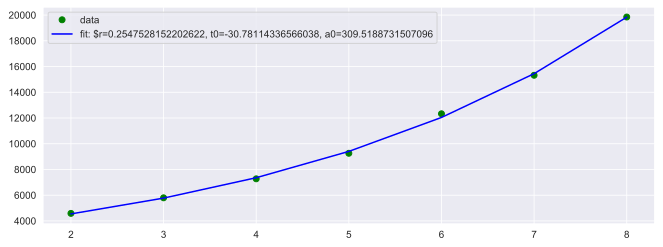

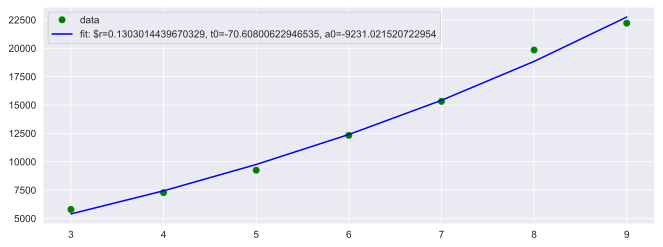

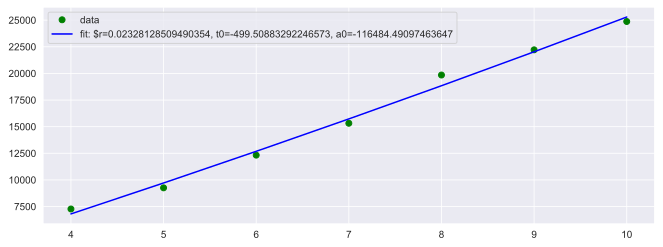

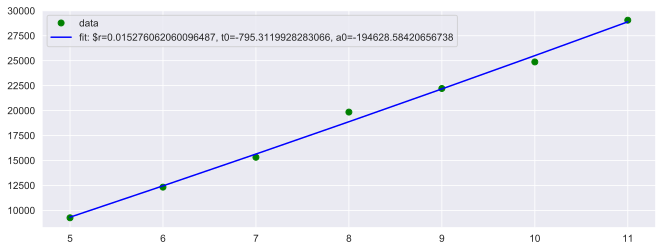

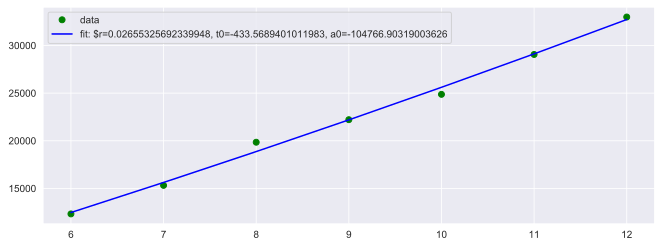

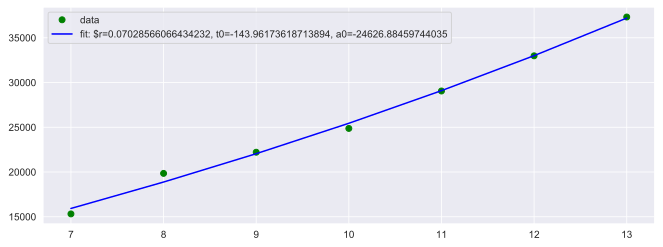

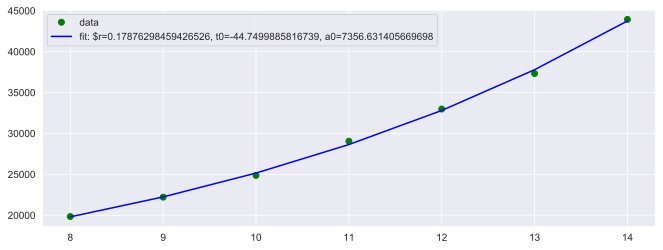

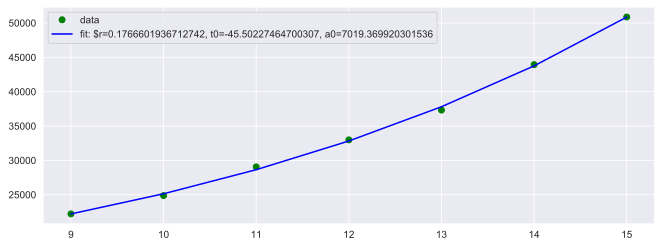

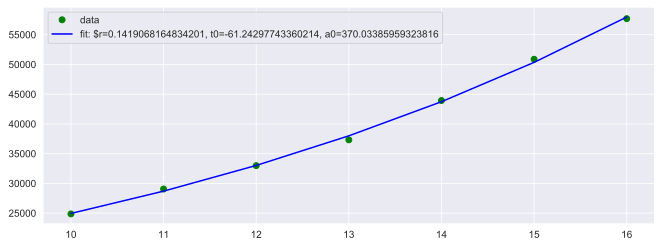

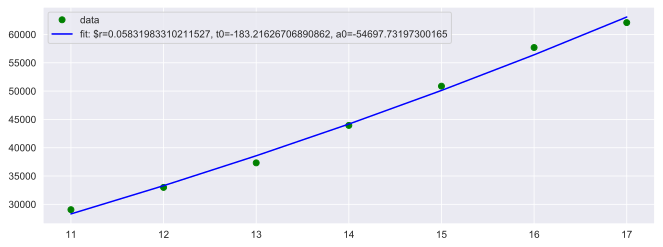

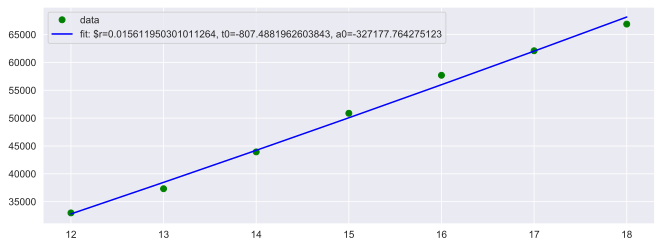

In [18]:
    
c = stack_country('Germany')
p_confirmed = grow_rate_n_days(c['confirmed'][-20:])
#

In [19]:
p_confirmed.tail(n=10)

,r,t0,a0,chi2
2020-03-22,0.130301,-70.608,-9231.02,NaN
2020-03-23,0.0232813,-499.509,-116484,NaN
2020-03-24,0.0152761,-795.312,-194629,NaN
2020-03-25,0.0265533,-433.569,-104767,NaN
2020-03-26,0.0702857,-143.962,-24626.9,NaN
2020-03-27,0.178763,-44.75,7356.63,NaN
2020-03-28,0.17666,-45.5023,7019.37,NaN
2020-03-29,0.141907,-61.243,370.034,NaN
2020-03-30,0.0583198,-183.216,-54697.7,NaN
2020-03-31,0.015612,-807.488,-327178,NaN


In [20]:
p_confirmed['double_time'] = double_time(p_confirmed['r'])

In [21]:
p_confirmed.tail(n=20)

,r,t0,a0,chi2,double_time
2020-03-12,NaN,NaN,NaN,NaN,NaN
2020-03-13,NaN,NaN,NaN,NaN,NaN
2020-03-14,NaN,NaN,NaN,NaN,NaN
2020-03-15,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,NaN,NaN,NaN,NaN
2020-03-17,NaN,NaN,NaN,NaN,NaN
2020-03-18,NaN,NaN,NaN,NaN,NaN
2020-03-19,0.222704,-36.5868,-1003.65,NaN,3.11241
2020-03-20,0.257547,-30.3351,438.824,NaN,2.69135
2020-03-21,0.254753,-30.7811,309.519,NaN,2.72086


Log basics ...

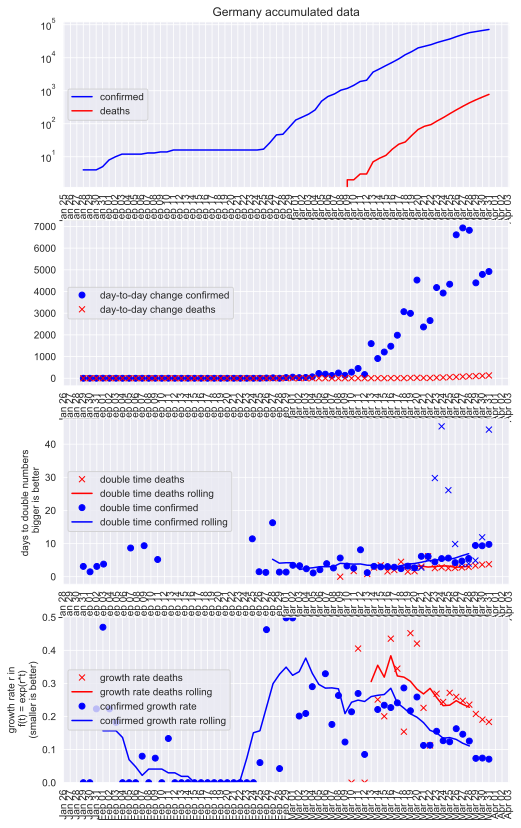

In [22]:
ax0, ax1, ax2, ax3 = overview_plot(c)
ax2.plot(p_confirmed.index, p_confirmed['double_time'], 'xb', label='double time confirmed fit')


In [23]:
from math import log 
log(2)/log(0.5)

-1.0

From https://en.wikipedia.org/wiki/Doubling_time
    
$$\Delta t = (t_2 - t_1) * \left(\frac{\log(2)}{\log
    \left(\frac{f(t_2)}{f(t_1)}\right)}\right)$$

In [24]:
from math import log
def double_time_exponential2(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate2(double_time):
    return log(2)/double_time


t1, t2, q1, q2 = 0, 1, 1, 2
double_time_exponential2(t1, t2, q1, q2), growth_rate2(double_time_exponential2(t1, t2, q1, q2) )

(1.0, 0.6931471805599453)

In [25]:
2**(1/double_time_exponential2(0, 1, 1, 21))

21.000000000000007

In [26]:
2/math.exp(1)

0.7357588823428847

In [27]:
math.exp(0.5)/2

0.8243606353500641

In [28]:
math.exp(0.6931471805599453*4)

15.999999999999998

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


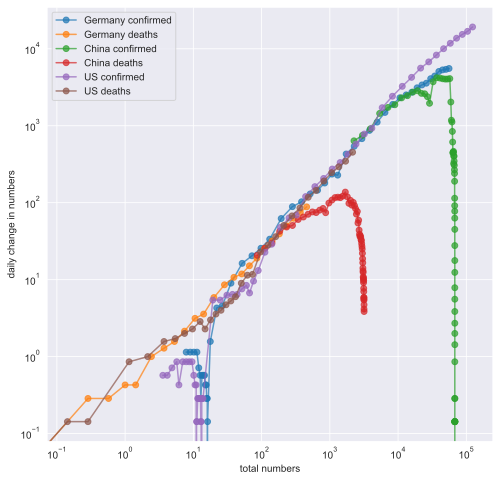

In [29]:
def logplots(c, columns, ax=None, alpha=0.7):
    """Dataframe c with colunmname 'column' contains the data we are interested in.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax = ax
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        pass
    
    for col in columns:
        assert col in c.columns
        c2 = c.copy()
        c2['change'] = c2[col].diff()
    
        ax.plot(c2[col], c2['change'], '-o', label=c.country + " " + col, alpha=alpha) 
    
    ax.legend()
    ax.set_xlabel("total numbers")
    ax.set_ylabel("daily change in numbers")
    return ax

    
    
c = stack_country("Germany")
c_roll = c[['confirmed', 'deaths']].rolling(7, center=True).mean()
c_roll.country = c.country
ax = logplots(c_roll, ['confirmed', 'deaths'])

c = stack_country("China")
c_roll = c[['confirmed', 'deaths']].rolling(7, center=True).mean()
c_roll.country = c.country
ax = logplots(c_roll, ['confirmed', 'deaths'], ax=ax)

#c = stack_country("Italy")
#c_roll = c[['confirmed', 'deaths']].rolling(7, center=True).mean()
#c_roll.country = c.country
#ax = logplots(c_roll, ['confirmed', 'deaths'], ax=ax)

#c = stack_country("Spain")
#c_roll = c[['confirmed', 'deaths']].rolling(7, center=True).mean()
#c_roll.country = c.country
#ax = logplots(c_roll, ['confirmed', 'deaths'], ax=ax)

c = stack_country("US")
c_roll = c[['confirmed', 'deaths']].rolling(7, center=True).mean()
c_roll.country = c.country
ax = logplots(c_roll, ['confirmed', 'deaths'], ax=ax)



In [30]:
c

,confirmed,deaths,days-td,days,new_confirmed,new_deaths,confirmed_pct,deaths_pct,deaths_double_time,confirmed_double_time,deaths_growth_rate,confirmed_growth_rate
2020-01-22,1,0,0 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,1,0,1 days,1.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-24,2,0,2 days,2.0,1,0,2.000000,NaN,NaN,1.000000,NaN,0.693147
2020-01-25,2,0,3 days,3.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-26,5,0,4 days,4.0,3,0,2.500000,NaN,NaN,0.756471,NaN,0.916291
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,101657,1581,65 days,65.0,17821,372,1.212570,1.307692,2.583825,3.596246,0.268264,0.192742
2020-03-28,121478,2026,66 days,66.0,19821,445,1.194979,1.281467,2.794882,3.891270,0.248006,0.178129
2020-03-29,140886,2467,67 days,67.0,19408,441,1.159766,1.217670,3.519596,4.676542,0.196939,0.148218
2020-03-30,161807,2978,68 days,68.0,20921,511,1.148496,1.207134,3.682074,5.006364,0.188249,0.138453


In [31]:
confirmed.loc['US']

Province/State            NaN
2020-01-22 00:00:00         1
2020-01-23 00:00:00         1
2020-01-24 00:00:00         2
2020-01-25 00:00:00         2
                        ...  
2020-03-27 00:00:00    101657
2020-03-28 00:00:00    121478
2020-03-29 00:00:00    140886
2020-03-30 00:00:00    161807
2020-03-31 00:00:00    188172
Name: US, Length: 71, dtype: object